In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('AAPL', start="2020-01-01", end="2025-08-01", auto_adjust=True)
data.columns = data.columns.droplevel(1)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data['MA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['MA200'] = data['Close'].ewm(span=200, adjust=False).mean()

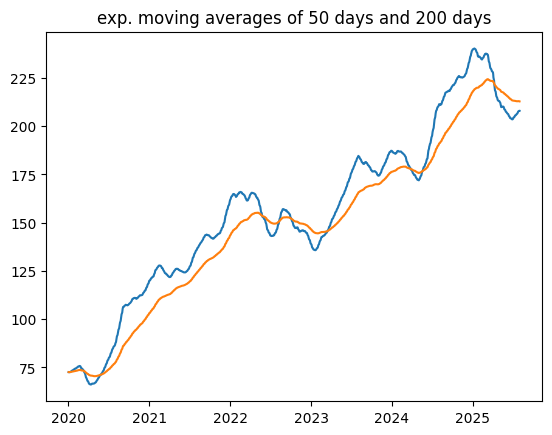

In [ ]:
plt.title('exp. moving averages of 50 days and 200 days')
plt.plot(data['MA50'])
plt.plot(data['MA200'])

In [ ]:
data['Signal'] = 0
data['Signal'][200:] = (data['MA50'][200:] > data['MA200'][200:]).astype(int)

/tmp/ipython-input-2852352634.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][200:] = (data['MA50'][200:] > data['MA200'][200:]).astype(int)
/tmp/ipython-input-2852352634.py:2: SettingWithCopyWarning: 
A value is trying to

In [ ]:
# Daily returns of the stock
data['Return'] = data['Close'].pct_change()   #pct change means percent change

# Strategy returns: only earn returns when Signal == 1
data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']

#shifts the signal down by one day → you act on yesterday’s signal today (to avoid lookahead bias)

# Cumulative returns
data['Cumulative_Market'] = (1 + data['Return']).cumprod()  #cumprod means compound product. ie 1 dollar is invested just compounded over time.
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod() # 1 dollar is invested as per the strategy. so if yesyerdays signal was 0 or -1 we do not earn anything.

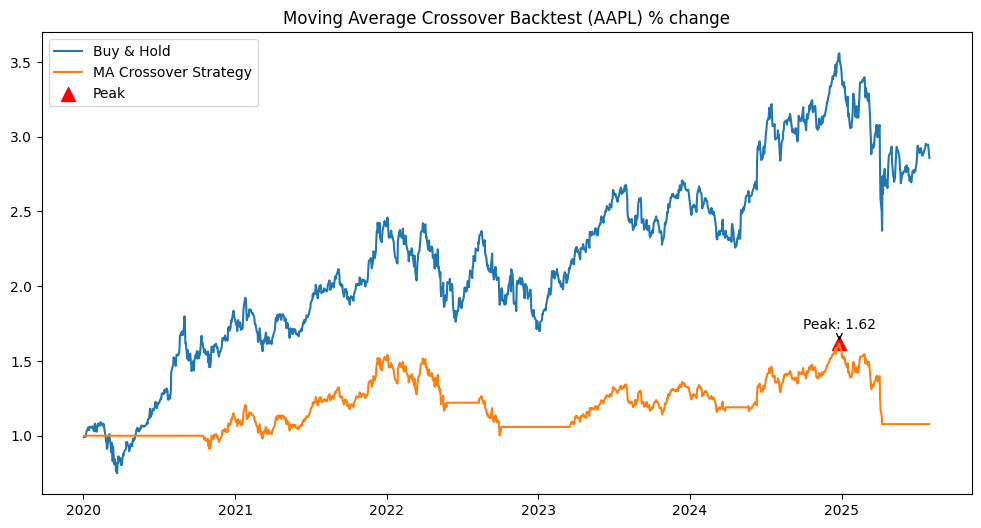

In [30]:
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative_Market'], label='Buy & Hold')
plt.plot(data['Cumulative_Strategy'], label='MA Crossover Strategy')
peak_idx = data['Cumulative_Strategy'].idxmax()
peak_val = data['Cumulative_Strategy'].max()

# Mark the peak
plt.scatter(peak_idx, peak_val, color='red', s=100, marker='^', label='Peak')

# Annotate the peak
plt.annotate(f'Peak: {peak_val:.2f}',
             xy=(peak_idx, peak_val),
             xytext=(peak_idx, peak_val + 0.1),  # offset a bit above the marker
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='center')
# Mark the peak
plt.legend()
plt.title("Moving Average Crossover Backtest (AAPL) % change")
plt.show()


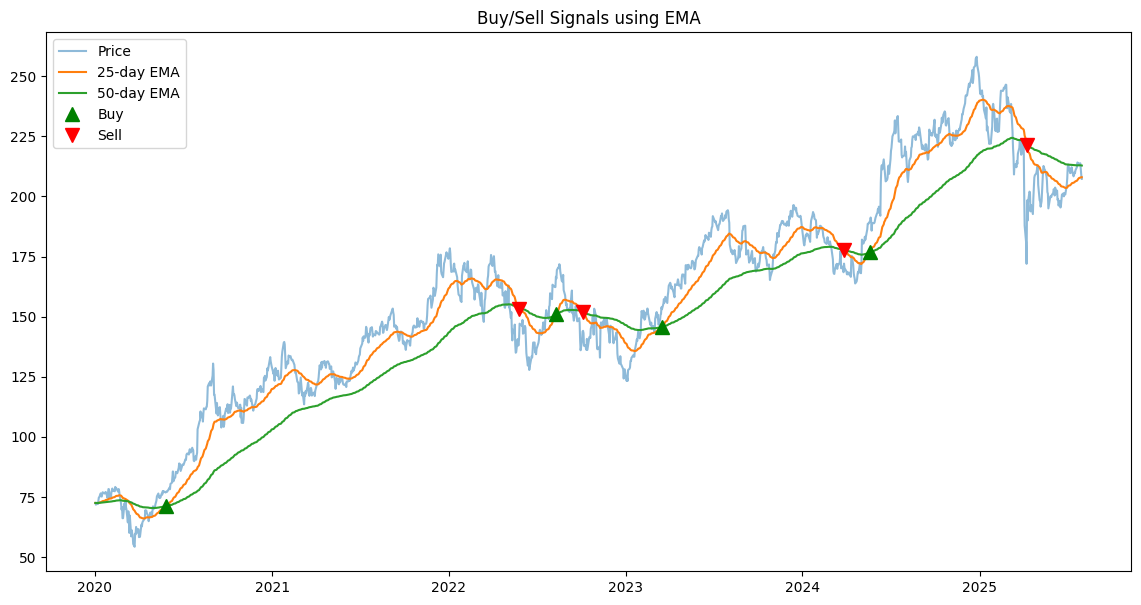

In [ ]:
 # Position changes (1 = buy, -1 = sell)  we trade on the basis of this position change
data['Position'] = data['Signal'].diff() ### checks the difference of signal bw Nth day and N-1th day. it can be either 0 (meaning no change), 1 (ma50 is higher than ma200) meaning buy or -1 meaning sell.

plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Price', alpha=0.5)
plt.plot(data['MA25'], label='25-day EMA')
plt.plot(data['MA50'], label='50-day EMA')

# Buy signals
plt.plot(data[data['Position'] == 1].index,
         data['MA25'][data['Position'] == 1],
         '^', markersize=10, color='g', label='Buy')

# Sell signals
plt.plot(data[data['Position'] == -1].index,
         data['MA25'][data['Position'] == -1],
         'v', markersize=10, color='r', label='Sell')

plt.legend()
plt.title("Buy/Sell Signals using EMA")
plt.show()
